In [1]:
import numpy
from matplotlib import pyplot
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# load the dataset
dataframe = read_csv('intecleaned-correct.csv',usecols=[1,2,4,5,6,7,8,9])
dataset = dataframe.values
#将整型变为float
dataset = dataset.astype('float32')

# fix random seed for reproducibility
numpy.random.seed(7)
# normalize the dataset
scaler_y = MinMaxScaler(feature_range=(0, 1))#功率数据归一化，之后还原预测结果要用
Y = scaler_y.fit_transform(dataset[:,5:6])

scaler_y1 = MinMaxScaler(feature_range=(0, 1))#风速数据归一化
Y1 = scaler_y1.fit_transform(dataset[:,6:7])

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset.shape

(43584, 8)

In [6]:
datasetCopy = dataset.copy()
datasetCopy.shape

(43584, 8)

In [2]:
!pip install keras==2.2.4

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [3]:
import keras
from keras.layers import Dense, Input
from keras.models import Model

Using TensorFlow backend.


In [7]:
input = Input(shape=(8,))
encoded = Dense(128, activation='relu')(input)
encoded1 = Dense(64, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded1)
decoded1 = Dense(8, activation='tanh')(decoded)
autoencoder = Model(input=input, output=decoded1)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(datasetCopy, datasetCopy, epochs=20, batch_size=128, verbose=1)

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`



Epoch 1/20





43584/43584 [==============================] - 3s 64us/step - loss: 0.0155
Epoch 2/20
43584/43584 [==============================] - 1s 19us/step - loss: 3.6664e-04
Epoch 3/20
43584/43584 [==============================] - 1s 19us/step - loss: 2.0370e-04
Epoch 4/20
43584/43584 [==============================] - 1s 19us/step - loss: 1.4944e-04
Epoch 5/20
43584/43584 [==============================] - 1s 19us/step - loss: 1.2463e-04
Epoch 6/20
43584/43584 [==============================] - 1s 19us/step - loss: 1.0866e-04
Epoch 7/20
43584/43584 [==============================] - 1s 19us/step - loss: 9.7435e-05
Epoch 8/20
43584/43584 [==============================] - 1s 19us/step - loss: 8.6387e-05
Epoch 9/20
43584/43584 [==============================] - 1s 19us/step - loss: 7.9048e-05
Epoch 10/20
43584/43584 [==============================] - 1s 19us/step - loss: 7.1690e-05
Epoch 11/20
43584/43584 [==============================] - 1s 19us/step - loss: 6.2705e-05
Epoch 

In [8]:
encoderModel = Model(input=input, output=encoded1)
encoded_input = Input(shape=(64,))  
decoder_layer = autoencoder.layers[-1]  
decoderModel = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
encoded_data = encoderModel.predict(datasetCopy)  
datasetCopy = decoderModel.predict(encoded_data)
#trainnewX = autoencoder.predict(train_X)

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [9]:
datasetCopy.shape

(43584, 8)

In [10]:
def create_dataset(dataset,dataset1, look_back,look_lag,data_step):
    main_dataX, main_dataY ,auxi_dataX,auxi_dataY= [], [],[],[]
    for i in range(0,len(dataset)-look_back-look_lag+1,data_step):
        a = dataset[i:(i+look_back), 1:8] #前一天的短期预测湿度、短期预测风向、短期预测温度、
                                        #短期预测气压、实际功率、实际风速都作为输入特征（共7个）
        c = dataset[(i+look_back):(i+look_back+look_lag),1:5]#当天的短期预测湿度、短期预测风向、短期预测温度、短期预测气压作为特征（共4个）
        d = dataset[(i+look_back):(i+look_back+look_lag),7:8]#当天短期预测风速作为特征（共1个）
        e = numpy.hstack([a,c])
        e = numpy.hstack([d,e])#把上面的特征都合在一起，共12个特征
        main_dataX.append(e) #主要输入
        b = dataset1[(i+look_back):(i+look_back+look_lag),5]
        main_dataY.append(b) #主要输出 需要预测的功率数据
    return numpy.array(main_dataX), numpy.array(main_dataY)#,numpy.array(auxi_dataX),numpy.array(auxi_dataY)


look_back = 16
look_lag = 16
train_size = 364*96
test_size = len(dataset) - train_size
train, test = datasetCopy[0:train_size,:], datasetCopy[train_size-look_back:len(dataset),:]
train1, test1 = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
train_mainX, train_mainY = create_dataset(train, train1,look_back,look_lag,4)#,train_auxiX,train_auxiY
test_mainX, test_mainY = create_dataset(test, test1,look_back,look_lag,16)#,test_auxiX,test_auxiY

# reshape input to be [samples, time steps, features]
train_mainX = numpy.reshape(train_mainX, (train_mainX.shape[0], look_back, 12))

test_mainX = numpy.reshape(test_mainX, (test_mainX.shape[0], look_back, 12))

In [11]:
from keras.layers import Dense, LSTM,Dropout
from keras.models import Sequential
model = Sequential() 
model.add(LSTM(units=48, return_sequences=True, 
               input_shape=(train_mainX.shape[1],train_mainX.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=48,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units = look_lag))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  
history = model.fit(train_mainX, train_mainY, epochs = 100,batch_size = 64,validation_split=0.33, shuffle=True)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5848 samples, validate on 2881 samples
Epoch 1/100
5848/5848 [==============================] - 10s 2ms/step - loss: 0.0433 - val_loss: 0.0179
Epoch 2/100
5848/5848 [==============================] - 7s 1ms/step - loss: 0.0168 - val_loss: 0.0187
Epoch 3/100
5848/5848 [==============================] - 7s 1ms/step - loss: 0.0148 - val_loss: 0.0129
Epoch 4/100
5848/5848 [==============================] - 7s 1ms/step - loss: 0.0130 - val_loss: 0.0105
Epoch 5/100
5848/5848 [==============================] - 7s 1ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 6/100
5848/5848 [==============================] - 7s 1ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 7/100
5848/5848 [==============================] - 7s 1ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 8/100
5848/584

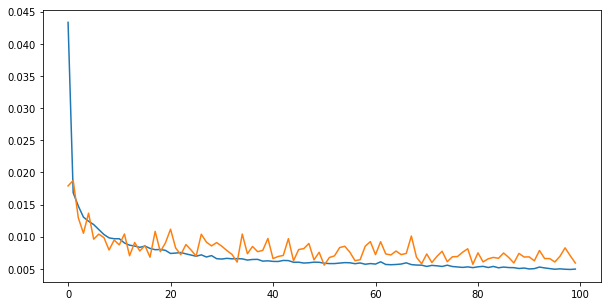

In [12]:
pyplot.figure(figsize=(10,5))
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')

In [13]:
testPredict = model.predict(test_mainX)

In [14]:
testPredict = testPredict.reshape(-1,1)
testPredict = scaler_y.inverse_transform(testPredict)
testPredict

array([[27.528278],
       [27.887272],
       [28.576935],
       ...,
       [33.83101 ],
       [33.41471 ],
       [33.32479 ]], dtype=float32)

In [15]:
testPredict.shape

(8640, 1)

In [16]:
test_mainY = test_mainY.reshape(-1,1)
test_mainY = scaler_y.inverse_transform(test_mainY)
test_mainY.shape

(8640, 1)

In [17]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def result(testY,testPredict):
    mse = mean_squared_error(testY,testPredict)
    mae = mean_absolute_error(testY,testPredict)
    r_square = r2_score(testY,testPredict)
    print("MSE:",mse)
    print("MAE:",mae)
    print("R_Square:",r_square)
    rmse = math.sqrt(mse)
    print("RMSE:",rmse)
    capacity = 49.5
    print("NRMSE:",1 - rmse/capacity)
    p_hme = 0
    whole_power = 49.5
    for l in range(testY.shape[0]):
        if testY[l] <= whole_power * 0.03 and testPredict[l] <= whole_power * 0.03:
            continue
        p_hme = p_hme + abs(testY[l] / (testY[l] + testPredict[l]) - 0.5) * abs(testPredict[l] -testY[l]) / np.sum(np.abs(testPredict - testY))
    p_hme =  1 - 2 * p_hme
    print('E', p_hme)

In [18]:
import numpy as np
predictions_1 = testPredict[0:31*96,0]
predictions_2 = testPredict[31*96:59*96,0]
predictions_3 = testPredict[59*96:90*96,0]

test_labels_1 = test_mainY[0:31*96,0]
test_labels_2 = test_mainY[31*96:59*96,0]
test_labels_3 = test_mainY[59*96:90*96,0]

print("2019年1-3月结果：")
result(test_mainY,testPredict)
print("2019年1月结果：")
result(test_labels_1,predictions_1)
print("2019年2月结果：")
result(test_labels_2,predictions_2)
print("2019年3月结果：")
result(test_labels_3,predictions_3)

2019年1-3月结果：
MSE: 11.851686
MAE: 2.5919402
R_Square: 0.93491465030422
RMSE: 3.4426277062713035
NRMSE: 0.9304519655298726
E [0.7901397]
2019年1月结果：
MSE: 11.221401
MAE: 2.6888688
R_Square: 0.9315188012184815
RMSE: 3.349835998164628
NRMSE: 0.9323265454916236
E 0.8282020540776601
2019年2月结果：
MSE: 11.443259
MAE: 2.5011034
R_Square: 0.9387267225441517
RMSE: 3.3827886778805407
NRMSE: 0.9316608347902922
E 0.7835031761801775
2019年3月结果：
MSE: 12.850872
MAE: 2.5770578
R_Square: 0.9309890829561962
RMSE: 3.5848112976549995
NRMSE: 0.9275795697443434
E 0.7562432651032504


In [19]:
#原系统准确率
testorin=dataframe.values[train_size:,0]
testorin=testorin.reshape(8640,1)
systempredictions_1 = testorin[0:31*96,0]
systempredictions_2 = testorin[31*96:59*96,0]
systempredictions_3 = testorin[59*96:90*96,0]
#原始系统准确率
print("原始系统准确率:")
print("2019年1-3月结果：")
result(test_mainY,testorin)
print("2019年1月结果：")
result(test_labels_1,systempredictions_1)
print("2019年2月结果：")
result(test_labels_2,systempredictions_2)
print("2019年3月结果：")
result(test_labels_3,systempredictions_3)

原始系统准确率:
2019年1-3月结果：
MSE: 38.90323077467954
MAE: 4.73843288221362
R_Square: 0.7863569507222773
RMSE: 6.237245447685985
NRMSE: 0.8739950414608892
E [0.66917906]
2019年1月结果：
MSE: 38.48454371279563
MAE: 4.870769504471107
R_Square: 0.7651391491589099
RMSE: 6.203591194847999
NRMSE: 0.8746749253566061
E 0.7053141024294813
2019年2月结果：
MSE: 43.47097008356602
MAE: 5.008162211467779
R_Square: 0.7672333948800686
RMSE: 6.593251859558076
NRMSE: 0.8668029927362004
E 0.6714997321255596
2019年3月结果：
MSE: 35.19621781563373
MAE: 4.3624697690168945
R_Square: 0.8109915717941774
RMSE: 5.932640037591504
NRMSE: 0.8801486861092626
E 0.6264273692486862


In [20]:
new_data = numpy.hstack([test_mainY,testorin,testPredict])
import pandas as pd
new_data = pd.DataFrame(new_data,columns= ['实际功率','原系统预测功率','超短期预测功率'])
new_data.to_csv('AE_lstm-ushort-93.04.csv', index=False, sep=',')